In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-bengali/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-bengali/classification')

In [6]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,title,article,label
0,এই অভিনেতার ‘প্রস্তাব’ মানলে ভারতীয় সিনেমার খো...,স্রেফ দু’টি টুইটেই সোশ্যাল মিডিয়ায় তোলপাড় ফে...,entertainment
1,"সচিন সাংসদ হয়েছেন, তাই চিন্তা কম জেটলির। কেন?",একবার রেল বাজেট। একবার সাধারণ বাজেট। খবরের শি...,national
2,ক্রিকেটার থেকে গাইড! জাতীয় দলের ক্রিকেটারের অব...,কিছুদিন আগেই রাজ্যের গাইড বনে গিয়েছিলেন চেতেশ...,sports
3,"দুষ্কৃতীদের নজরে এটিএম, হাল হকিকত্ ঘুরে দেখলেন...",কলকাতায় দুষ্কৃতীদের নজরে এখন বিভিন্ন ব্যাঙ্কের...,kolkata
4,"সৌজন্যের বালাই নেই, দিনভর আকচা আকচি কং-বিজেপি’র",সারা দিন আকচা আকচিতেই কাটিয়ে দিল দেশের দুই বৃহ...,national


In [7]:
valid_df = pd.read_csv(path/'valid.csv')
valid_df.head()

,title,article,label
0,মাঠে নেমেই অর্ধশতক! রাহুল জানালেন তাঁর সাফল্যে...,গলেরই পুনরাবৃত্তি হয়তো কলম্বোয় ঘটতে চলেছে। শ্...,sports
1,কুমার সম্ভব?,তাহলে কি ঘাটা-আঘাটায় পুলিশের মারধর খেয়ে নীরবে...,state
2,স্বামী-স্ত্রীর ঘনিষ্ঠ মুহূর্তের ছবি সোশ্যাল মি...,পণের দাবিতে নজিরবিহীন ব্ল্যাকমেল স্ত্রীকে। স্ব...,kolkata
3,‘এবেলা’ খবরের প্রতিক্রিয়া: অভীকের সঙ্গে কথা হল...,বাংলার প্যারালিম্পিক সংস্থার সঙ্গে যোগাযোগ হল...,sports
4,‘অ্যায় দিল হ্যায় মুশকিল’-এই অভিনেত্রী কি অন্তঃ...,"‘বোল্ড’, তথাকথিত পারিবারিক ছবির গণ্ডী থেকে বে...",entertainment


In [8]:
print('In Training data:')
for cls in train_df['label'].unique():
    print(cls, (train_df['label'] == cls).sum())

In Training data:
entertainment 1197
national 1420
sports 1302
kolkata 4625
state 2200
international 538
sport 18
nation 13
world 10
travel 1


In [9]:
print('In Validation data:')
for cls in valid_df['label'].unique():
    print(cls, (valid_df['label'] == cls).sum())

In Validation data:
sports 331
state 570
kolkata 1143
entertainment 285
international 125
national 370
world 4
nation 2
sport 2


In [10]:
train_df['title'][0]

'এই অভিনেতার ‘প্রস্তাব’ মানলে ভারতীয় সিনেমার খোলনলচে বদলে যাবে'

In [11]:
train_df.shape, valid_df.shape

((11324, 3), (2832, 3))

In [12]:
train_df[train_df['title'].isnull()].shape, valid_df[valid_df['article'].isnull()].shape

((0, 3), (0, 3))

In [13]:
label_cols = list(range(2,train_df.shape[1]))

In [14]:
print(label_cols)

[2]


In [15]:
id_to_col = list(train_df.columns)

In [16]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [17]:
class BengaliTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/bengali_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [18]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/bengali_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [19]:
# 30,000 is the vocab size that we chose in sentencepiece
bengali_vocab = Vocab(itos)

In [20]:
tokenizer = Tokenizer(tok_func=BengaliTokenizer, lang='bn')

In [21]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [22]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, text_cols=[0,1], label_cols=label_cols, tokenizer=tokenizer, vocab=bengali_vocab, bs=16)

In [23]:
data_lm.save()

In [24]:
data_lm.show_batch()

idx,text
0,"্য ক্ত ▁করা ▁ঘিরে ▁আলোচনা ▁চলছে ▁সর্বত্র । ▁চেন্নাইয়ে র ▁রাস্তায় ▁দিনে দু পুরে ▁এক ▁মহিলাকে ▁খুন ▁করা ▁হয়েছে ▁সম্প্রতি । ▁নারী সু রক্ষা ▁নিয়ে ▁চলছে ▁আলোচনা , ▁মত ▁বিনিময় । ▁ঠিক ▁এই রকম ▁একটি ▁পরিস্থিতিতে ▁সিদ্ধার্থ ের ▁জোড়া ▁টু ইট ▁আত্ম স মা লোচনা র ▁সামিল । ▁কীভাবে ▁এই ▁সামাজিক ▁অভিশাপ ের ▁নেপথ্য ে ▁সিনেমার ও ▁দায় ▁থেকে ▁যায় , ▁তা ▁স্পষ্ট ভাষা য় ▁তুলে ▁ধরেছেন ▁সিদ্ধার্থ । ▁কোনও"
1,"শার্ট ▁আর ▁জিন ্সে ▁করি না । ▁তাঁর ▁কোলে ▁ছাই র ঙা ▁বেবি স্যুট ▁পরে ▁প্রাণ খোলা ▁হাসি তে ▁তৈমুর । ▁আর ▁তৈমুর ের ▁মাথায় ▁চু মু ▁দিচ্ছেন ▁নায়িকা । ▁x x bo s ▁অ্যা ঞ্জি ও গ্রাম ▁করতে ▁গিয়ে ▁ধমনী ▁ছিঁড়ে ▁মৃত্যু , ▁কাঠ গড়া য় ▁এসএস কে এম ▁অ্যা ঞ্জি ও গ্রাম ▁করা তে ▁গিয়ে ▁বি পত্তি । ▁অস্ত্রোপচার ের ▁ভুলে ▁প্রবল ▁রক্তক্ষরণ ে ▁মৃত্যু ▁হল ▁রোগী নির"
2,"▁সি পিএম ▁সাংসদ ▁মহম্মদ ▁সেলিম ের ▁খো ঁচা , ▁' ইতিহাস ের ▁কি ▁পরি হাস ! ' ▁জি ▁২৪ ▁ঘণ্টা কে ▁ফোনে ▁তিনি ▁বলেন , ▁' ' নব ান্ন ▁এখন ▁নিজেকে ▁বাঁচাতে ▁ব্যস্ত । ▁রাজ্যের ▁মানুষকে ▁বাঁচা বে ▁কি ? ▁মমতা ▁বন্দ্যোপাধ্যায় ▁ভয় ▁পেয়েছেন । ▁টোল প্ল াজ ায় ▁জলপাই ▁পোশাক ▁পরা ▁ব্যক্তিদের ▁দেখে ▁দিদি মনি ▁বলেছিলেন ▁বাড়ি ▁ফির ব ▁না । ▁এবার ও ▁সেই ▁একই ▁লক্ষণ । ▁ইতিহাসের ▁কি"
3,"ওয়াল কে ▁দু ’ সপ্তাহ ▁বিশ্রাম ে ▁থাকার ▁পরামর্শ ▁দিলেন ▁চিকিৎসক রা । ▁এদিকে , ▁চিন ▁ওপেন ে ▁হার লেও ▁বিশ্ব ▁ র ▁্যাঙ্কিংয়ে ▁দু ’ ন ম্বর ▁স্থান ই ▁ধরে ▁রেখেছেন ▁সাই না । ▁জিতে ▁দু ’ ন ম্বর ে ▁উঠল ▁দিল্লি ▁বৃহস্পতিবার ▁আইএস এল ে ▁পু ণে ▁সিটি ▁এফসি - কে ▁৩ - ১ ▁গোলে ▁হারিয়েছে ▁দিল্লি ▁ডায়নামো জ । ▁এই ▁জয়ের ▁সুবাদে ▁পয়েন্ট ▁টেবিল ের ▁দু ’"
4,"কে ▁এড়িয়ে ই ▁চলেছেন ▁মমতা , ▁সেখানে ▁তাঁর ▁আবির্ভাব ের ▁লগ্ন কে ▁স্মরণীয় ▁করতে ▁হবে । ▁‘ জ মি ’ ▁পাচ্ছে ▁সি ঙ্গু র । ▁‘ জ মি ’ ▁চাই ছেন ▁মমতা । ▁x x bo s ▁আজ ▁নেতাজি ▁ইন্ডোর ে ▁তৃণমূল ের ▁সাংগঠনিক ▁নির্বাচন ▁আজ ▁নেতাজি ▁ইন্ডোর ে ▁তৃণমূল ের ▁সাংগঠনিক ▁নির্বাচন । ▁প্রত্যাশিত ভাবেই ▁দলের ▁সভানেত্রী ▁হতে ▁চলেছেন ▁মমতা ▁বন্দ্যোপাধ্যায় । ▁নারদ কাণ্ড ের ▁পর ▁দল ▁অস্বস্তি তে"


In [25]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [26]:
# Loading the pretrained language model on bengali wikipedia
learn.load('/home/gaurav/PycharmProjects/nlp-for-bengali/language-model/BengaliDataset/models/third_bn_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (11324 items)
x: LMTextList
▁x x bo s ▁এই ▁অভিনেতার ▁‘ প্র স্তা ব ’ ▁মান লে ▁ভারতীয় ▁সিনেমার ▁খোল ন ল চে ▁বদলে ▁যাবে ▁স্ রে ফ ▁দু ’ টি ▁টু ইট েই ▁সোশ্যাল ▁মিডিয়া য় ▁তো ল পাড় ▁ফেলে ▁দিয়েছেন ▁সিদ্ধার্থ ▁সূর্য নারায়ণ । ▁এমন ▁দু ’ টি ▁কথা ▁তিনি ▁বলেছেন , ▁যা ▁একই সঙ্গে ▁সমাজ ▁এবং ▁সিনেমা কে ▁এক সু তো য় ▁বেঁধে ছে । ▁মহিলাদের ▁পিছু ▁নেওয়া , ▁তাঁদের ▁উত্ত ্য ক্ত ▁করা ▁ঘিরে ▁আলোচনা ▁চলছে ▁সর্বত্র । ▁চেন্নাইয়ে র ▁রাস্তায় ▁দিনে দু পুরে ▁এক ▁মহিলাকে ▁খুন ▁করা ▁হয়েছে ▁সম্প্রতি । ▁নারী সু রক্ষা ▁নিয়ে ▁চলছে ▁আলোচনা , ▁মত ▁বিনিময় । ▁ঠিক ▁এই রকম ▁একটি ▁পরিস্থিতিতে ▁সিদ্ধার্থ ের ▁জোড়া ▁টু ইট ▁আত্ম স মা লোচনা র ▁সামিল । ▁কীভাবে ▁এই ▁সামাজিক ▁অভিশাপ ের ▁নেপথ্য ে ▁সিনেমার ও ▁দায় ▁থেকে ▁যায় , ▁তা ▁স্পষ্ট ভাষা য় ▁তুলে ▁ধরেছেন ▁সিদ্ধার্থ । ▁কোনও ▁রাখ ঢ াক ▁না - করে ই ▁তিনি ▁বলেছেন , ▁সিনেমায় ▁এমনটি ▁একটি ▁স্বপ্ন ▁ফেরি ▁করার ▁চেষ্টা ▁চলে , ▁যা ▁সম্পূর্ণ ▁ভুল । ▁কীভাবে ? ▁সিদ্ধার্থ ▁তুলে ▁এনেছে ন ▁ভারতীয় ▁ছবিতে ▁বহু - ব্যবহৃত ▁এবং ▁জনপ্

In [27]:
# Fine tuning the prtrained LM on current dataset

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


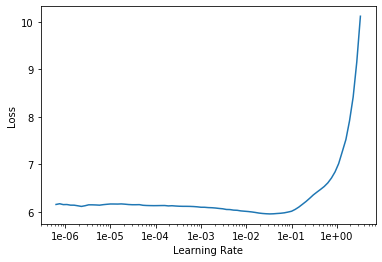

In [29]:
learn.recorder.plot()

In [30]:
learn.freeze()

In [31]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.136137,4.930380,0.241189,05:24


In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.678400,4.715336,0.258704,06:05
1,4.584887,4.592208,0.273000,06:06
2,4.319761,4.507034,0.283340,06:05
3,4.141273,4.459172,0.289931,06:05
4,4.010191,4.459523,0.290874,06:06


In [34]:
learn.predict('সামগ্রিক পরিস্থিতি',n_words=10)

'সামগ্রিক পরিস্থিতি ▁নিয়ে ▁ফেটে ▁পড়েছেন ss ! ▁ জিগ ্যে স ▁করল'

In [35]:
learn.save_encoder('fine_tuned_enc')

In [26]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=bengali_vocab, text_cols=[0,1], label_cols=label_cols, bs=16)

In [27]:
data_clas.show_batch()

text,target
"▁x x bo s ▁কিছু ▁সত্যি , ▁কিছু ▁বানানো ▁আমি ▁কখনও ▁পলি টি ক্যাল ▁মিটিং ▁শুনতে ▁যাই ▁না । ▁কারণ ▁আমি ▁জানি ▁নেতারা ▁কী ▁বলবে ন ▁বা ▁বলতে ▁পারেন । ▁আপনি ▁যদি ▁নেতার ▁নাম ▁আর ▁কী ▁উপলক্ষে ▁মিটিং ▁হচ্ছে , ▁কবে ▁হচ্ছে ▁আমাকে ▁বলতে ▁পারেন ▁তাহলে ▁আমি ▁ঐ ▁নেতার ▁বক্তব্য ▁মোটামুটি ▁আপনাকে ▁বলে ▁দিতে ▁পারি । ▁কিন্তু ▁কয়েকদিন ▁আগে ▁হঠাৎ ▁ফে ঁ সে ▁গেল াম । ▁ জিপি ও -",kolkata
"▁x x bo s ▁কোয়েল ের ▁চেহারা ▁ভেঙে ▁একদম ▁নতুন ▁ভাবে ▁দেখা ব , ▁এসব ে ▁আমি ▁বিশ্বাস ▁করি ▁না ▁বাঙালি য়ানা য় ▁ভরপুর ▁রম - কম ▁বানিয়ে ছেন ▁পরিচালক ▁মৈ নাক ▁ভৌমিক । ▁ছবির ▁নায়িকা ▁কোয়েল ▁মল্লিক । ▁এই ▁প্রথম ▁তাঁর ▁ছবিতে ▁কোনও ▁‘ সুপার স্টার ’ । ▁দু ’ জনের ▁সমীকরণ টা ▁ঠিক ▁কেমন ? ▁খোঁজ ▁নিল ▁‘ ও বেলা ’ । ▁ছবির ▁নাম ▁‘ ঘরে ▁অ্যান্ড ▁বাইরে",entertainment
"▁x x bo s ▁নায়িকা ▁সংবাদ ▁শুনতে ▁যেমন , ▁দেখতে ▁তেমন ▁নয় । ▁১০ ▁নম্বর ▁খাট াল ে ▁‘ এ বেলা র ▁সঙ্গে ▁চা ’ ▁হতেই ▁পারে ▁না ▁ ! ▁একটা ই ▁ভরসা , ▁আবাসন ের ▁নাম ▁‘ লেক ▁উইন্ডো ’ । ▁লেক ▁গার্ডেন ্সে ▁ঢোকা ▁ইস্ তক ▁খাট াল ের ▁কোনও ▁সন্ধান ▁মেলে নি । ▁তাঁর ▁বলে ▁দেওয়া ▁ম্যাপ মতো ▁এগোতে ▁এগোতে ▁ জিগ ্যে স ▁করা ▁গেল ▁এক",entertainment
▁x x bo s ▁' ' পু জোর ▁পর ▁আমরা ▁মার ের ▁বদলে ▁মার ▁দেব ' ' ▁বছর ▁ খানেক ▁আগেও ▁তাঁকে ▁কেউ ▁চিন ত ▁না । ▁প্রত্যক্ষ ▁রাজনীতি ▁করতেন ▁না । ▁গত ▁বিধানসভা ▁ভোট ের ▁আগে ▁হঠ া ত্ ই ▁বিজেপি র ▁মুখ ▁হয়ে ▁যান ▁ঝাড়গ্রাম ▁থেকে ▁উঠে ▁আসা ▁সেদিন ের ▁দিলীপ । ▁আর ▁আজ ▁পশ্চিমবঙ্গ ▁বিজেপি র ▁সর্ব ময় ▁কর্তা । ▁কীভাবে ▁তিনি ▁এলেন ▁রাজনীতিতে ? ▁আর এসএস,kolkata
"▁x x bo s ▁এ ▁বার ▁মদন কে ▁জে রা ▁করতে ▁চায় ▁সিবি আই ▁মন্ত্রীর ▁প্রাক্তন ▁আ প্ত ▁সহায়ক ের ▁বাড়িতে ▁সিবি আই ▁হানা ▁এবং ▁পরপর ▁দু ’ দিন ▁তাঁকে ▁ডেকে ▁পাঠিয়ে ▁জের ার ▁মধ্যেই ▁ইঙ্গিত টা ▁ছিল । ▁শুক্রবার ▁সিবি আই ▁সূত্রে ▁জানিয়ে ▁দেওয়া ▁হল , ▁সারদা ▁কেলেঙ্কারি তে ▁এ ▁বার ▁পরিবহণ মন্ত্রী ▁মদন ▁মিত্র কে ▁জিজ্ঞাসাবাদ ▁করতে ▁চায় ▁তারা । ▁সিবি আই ▁অধিকর্তা ▁রঞ্জিত ▁সি ন্ হা ▁সম্প্রতি",state


In [28]:
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']

In [29]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [30]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11324 items)
x: TextList
▁x x bo s ▁এই ▁অভিনেতার ▁‘ প্র স্তা ব ’ ▁মান লে ▁ভারতীয় ▁সিনেমার ▁খোল ন ল চে ▁বদলে ▁যাবে ▁স্ রে ফ ▁দু ’ টি ▁টু ইট েই ▁সোশ্যাল ▁মিডিয়া য় ▁তো ল পাড় ▁ফেলে ▁দিয়েছেন ▁সিদ্ধার্থ ▁সূর্য নারায়ণ । ▁এমন ▁দু ’ টি ▁কথা ▁তিনি ▁বলেছেন , ▁যা ▁একই সঙ্গে ▁সমাজ ▁এবং ▁সিনেমা কে ▁এক সু তো য় ▁বেঁধে ছে । ▁মহিলাদের ▁পিছু ▁নেওয়া , ▁তাঁদের ▁উত্ত ্য ক্ত ▁করা ▁ঘিরে ▁আলোচনা ▁চলছে ▁সর্বত্র । ▁চেন্নাইয়ে র ▁রাস্তায় ▁দিনে দু পুরে ▁এক ▁মহিলাকে ▁খুন ▁করা ▁হয়েছে ▁সম্প্রতি । ▁নারী সু রক্ষা ▁নিয়ে ▁চলছে ▁আলোচনা , ▁মত ▁বিনিময় । ▁ঠিক ▁এই রকম ▁একটি ▁পরিস্থিতিতে ▁সিদ্ধার্থ ের ▁জোড়া ▁টু ইট ▁আত্ম স মা লোচনা র ▁সামিল । ▁কীভাবে ▁এই ▁সামাজিক ▁অভিশাপ ের ▁নেপথ্য ে ▁সিনেমার ও ▁দায় ▁থেকে ▁যায় , ▁তা ▁স্পষ্ট ভাষা য় ▁তুলে ▁ধরেছেন ▁সিদ্ধার্থ । ▁কোনও ▁রাখ ঢ াক ▁না - করে ই ▁তিনি ▁বলেছেন , ▁সিনেমায় ▁এমনটি ▁একটি ▁স্বপ্ন ▁ফেরি ▁করার ▁চেষ্টা ▁চলে , ▁যা ▁সম্পূর্ণ ▁ভুল । ▁কীভাবে ? ▁সিদ্ধার্থ ▁তুলে ▁এনেছে ন ▁ভারতীয় ▁ছবিতে ▁বহু - ব্যবহৃত ▁এবং ▁জনপ্রিয় 

In [41]:
learn.freeze()

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


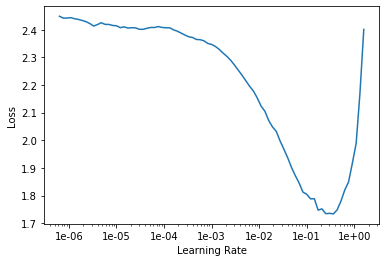

In [43]:
learn.recorder.plot()

In [44]:
learn.loss_func.func

CrossEntropyLoss()

In [45]:
kappa = KappaScore()

In [46]:
learn.metrics = [kappa, accuracy]

In [47]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.440978,0.322971,0.865805,0.899011,03:45


In [48]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.278968,0.984073,0.902354,0.926201,03:34


In [49]:
learn.save('second-full')

In [31]:
learn.load('second-full')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11324 items)
x: TextList
▁x x bo s ▁এই ▁অভিনেতার ▁‘ প্র স্তা ব ’ ▁মান লে ▁ভারতীয় ▁সিনেমার ▁খোল ন ল চে ▁বদলে ▁যাবে ▁স্ রে ফ ▁দু ’ টি ▁টু ইট েই ▁সোশ্যাল ▁মিডিয়া য় ▁তো ল পাড় ▁ফেলে ▁দিয়েছেন ▁সিদ্ধার্থ ▁সূর্য নারায়ণ । ▁এমন ▁দু ’ টি ▁কথা ▁তিনি ▁বলেছেন , ▁যা ▁একই সঙ্গে ▁সমাজ ▁এবং ▁সিনেমা কে ▁এক সু তো য় ▁বেঁধে ছে । ▁মহিলাদের ▁পিছু ▁নেওয়া , ▁তাঁদের ▁উত্ত ্য ক্ত ▁করা ▁ঘিরে ▁আলোচনা ▁চলছে ▁সর্বত্র । ▁চেন্নাইয়ে র ▁রাস্তায় ▁দিনে দু পুরে ▁এক ▁মহিলাকে ▁খুন ▁করা ▁হয়েছে ▁সম্প্রতি । ▁নারী সু রক্ষা ▁নিয়ে ▁চলছে ▁আলোচনা , ▁মত ▁বিনিময় । ▁ঠিক ▁এই রকম ▁একটি ▁পরিস্থিতিতে ▁সিদ্ধার্থ ের ▁জোড়া ▁টু ইট ▁আত্ম স মা লোচনা র ▁সামিল । ▁কীভাবে ▁এই ▁সামাজিক ▁অভিশাপ ের ▁নেপথ্য ে ▁সিনেমার ও ▁দায় ▁থেকে ▁যায় , ▁তা ▁স্পষ্ট ভাষা য় ▁তুলে ▁ধরেছেন ▁সিদ্ধার্থ । ▁কোনও ▁রাখ ঢ াক ▁না - করে ই ▁তিনি ▁বলেছেন , ▁সিনেমায় ▁এমনটি ▁একটি ▁স্বপ্ন ▁ফেরি ▁করার ▁চেষ্টা ▁চলে , ▁যা ▁সম্পূর্ণ ▁ভুল । ▁কীভাবে ? ▁সিদ্ধার্থ ▁তুলে ▁এনেছে ন ▁ভারতীয় ▁ছবিতে ▁বহু - ব্যবহৃত ▁এবং ▁জনপ্রিয় 

In [32]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final')])

epoch,train_loss,valid_loss,accuracy,time
0,0.241547,0.345347,0.929379,06:11
1,0.223376,0.214403,0.932203,05:54
2,0.114827,0.239484,0.937500,06:19
3,0.066007,0.214646,0.938912,06:06
4,0.060330,0.215553,0.937500,05:33


Better model found at epoch 0 with accuracy value: 0.9293785095214844.
Better model found at epoch 1 with accuracy value: 0.9322034120559692.
Better model found at epoch 2 with accuracy value: 0.9375.
Better model found at epoch 3 with accuracy value: 0.9389124512672424.


In [33]:
learn.predict('বেশ  কয়েক বছর আগের কলকাতা। বিবর্ণ পাড়া, বেরং বাড়ি, নোংরা সরু গলি। রঙের সমাহার নেই, নেই ঝলমলে আলোর রোশনাই। রয়েছে শুধু হৃদয়ের টান।')

(Category kolkata,
 tensor(2),
 tensor([1.0697e-03, 1.0184e-04, 9.7928e-01, 1.6902e-06, 3.5811e-04, 5.8906e-07,
         1.8019e-05, 1.9165e-02, 2.9632e-08, 6.7438e-06]))

In [34]:
learn.predict("প্রদর্শন বন্ধ করা যাবে না, ‘ভবিষ্যতের ভূত’ নিয়ে নির্দেশ সুপ্রিম কোর্টের")

(Category national,
 tensor(4),
 tensor([2.4883e-03, 3.3689e-02, 3.0939e-02, 1.4144e-04, 9.1924e-01, 1.2895e-04,
         1.0829e-02, 2.1951e-03, 2.0589e-07, 3.4490e-04]))

In [35]:
learn.predict("নিউজিল্যান্ডের মসজিদে হামলার ঘটনায় নিখোঁজ ৯ ভারতীয়")

(Category world,
 tensor(9),
 tensor([1.8768e-06, 1.6753e-01, 1.8347e-03, 1.3255e-02, 2.7985e-01, 3.4035e-02,
         2.8357e-02, 1.8055e-03, 1.0502e-01, 3.6831e-01]))

In [36]:
learn.predict("তৈরির উপাদান জানতে মিক্সারে ফোন গুঁড়ো করলেন বিজ্ঞানীরা")

(Category kolkata,
 tensor(2),
 tensor([2.0021e-01, 3.9891e-03, 7.3964e-01, 1.4497e-05, 1.8713e-02, 1.7400e-05,
         7.8013e-03, 2.9575e-02, 1.1148e-07, 3.7829e-05]))